In [2]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.nn.functional import relu
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import ssl
import os
import pandas as pd
import zipfile
from PIL import Image
import re
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms as tf

ssl._create_default_https_context = ssl._create_unverified_context

torch.hub.set_dir(d = "C:\\Users\\Ugne\\torch\\hub")

data_dir = "images"
classes =  ["Knife", "Handbag","Handgun"]


c:\Users\Ugne\Documents\studies\Python\DL-task1\.venv\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

## Downloading data

In [4]:
from openimages.download import download_dataset

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

#download_dataset(data_dir, classes, csv_dir=data_dir)

In [5]:
class_label_names = pd.read_csv(data_dir+'\class-descriptions-boxable.csv', names = ["label_name", "class"])
#class_label_names = class_label_names[class_label_names["class"].isin(classes)]

In [6]:
def read_annotations(dataset_type="train"):
    df = pd.read_csv(dataset_type+"-annotations-object-segmentation.csv")
    df["type"] = dataset_type
    return df

In [7]:
# File downloaded from https://storage.googleapis.com/openimages/web/download_v7.html#download-tfds

annotations = pd.concat([read_annotations(dataset_type=t) for t in ["train", "validation", "test"]])

annotations = annotations.merge(class_label_names, how = "left", left_on = "LabelName", right_on="label_name")

In [8]:
images_with_several_masks = annotations.sort_values(by = "LabelName")\
        .groupby("ImageID", as_index=False)\
        .agg(
            class_count = ("LabelName", "nunique"),
            class_list = ("class", pd.Series.to_list)
            )

images_with_several_masks = images_with_several_masks[images_with_several_masks["class_count"] >=2]
images_with_several_masks["class_set"] = images_with_several_masks["class_list"].apply(set)
images_with_several_masks["class_set"] = [', '.join(c) for c in images_with_several_masks["class_set"]]

In [9]:
images_per_class_set = images_with_several_masks.groupby("class_set", as_index = False).agg(
    images = ("ImageID", "count")
).sort_values(by = "images", ascending=False)

In [10]:
selected_class = "Car"
contains_class = [s for s in images_per_class_set["class_set"] if selected_class in s]

images_per_class_set[images_per_class_set["class_set"].isin(contains_class)][0:20]

,class_set,images
16292,"Wheel, Car",17790
3003,"Clothing, Car",1408
11573,"Person, Car",1366
15767,"Truck, Car",1152
1667,"Car, Bus",987
15808,"Truck, Car, Wheel",912
2028,"Car, Vehicle registration plate",845
16436,"Wheel, Car, Vehicle registration plate",791
11648,"Person, Car, Wheel",629
1837,"Car, Man",550


In [16]:
selected_classes = ["Person, Car, Skyscraper", "Person, Car", "Person, Skyscraper", "Skyscraper, Car"]

images_per_class_set[images_per_class_set["class_set"].isin(selected_classes)]

relevant_images = images_with_several_masks[images_with_several_masks["class_set"].isin(selected_classes)]
relevant_images["for_download"] = "train/"+relevant_images["ImageID"]

relevant_images[["for_download"]].to_csv("train_several_classes.txt", header=False, index=False)

In [17]:
#!python downloader.py "train_several_classes.txt" --download_folder="images/all" --num_processes=5

In [37]:
class_annotations = annotations[annotations["LabelName"].isin(class_label_names["label_name"])].sort_values(by = "ImageID")
class_annotations["ImageID_first_character"] = class_annotations["ImageID"].str.slice(0, 1)

class_annotations = class_annotations.merge(class_label_names, how = "left", left_on = "LabelName", right_on="label_name")

class_annotations.to_csv("selected_annotations.csv", index=False)

In [8]:
zip_file_groups = set(class_annotations["ImageID_first_character"])

In [9]:
def extract_specific_files_old(zip_path, target_files, output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            for target_file in target_files:
                if target_file in filename:
                    zip_ref.extract(filename, output_dir)

def get_target_files(annotation_df, group, class_name):
    downloaded_files = os.listdir("images/"+class_name.lower()+"/images")
    downloaded_image_ids = [d.replace(".jpg", "") for d in downloaded_files]
    target_files = list(annotation_df[(annotation_df["ImageID_first_character"] == group) &
                                   (annotation_df["class"] == class_name) &
                                   annotation_df["ImageID"].isin(downloaded_image_ids)]["MaskPath"])
    return target_files

def extract_specific_files(zip_path, target_files, output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            for target_file in target_files:
                if target_file in filename:
                    # Extract file into memory
                    file_data = zip_ref.read(filename)

                    # Generate new name 
                    new_name = re.match('[^_]*', filename).group()+".png"

                    # Join output dir and new file name
                    new_file_path = os.path.join(output_dir, new_name)

                    # Write file from memory to new location with new name
                    with open(new_file_path, 'wb') as f:
                        f.write(file_data)

def extract_specific_files_for_group(annotation_df, group, class_name, zip_prefix):
    target_files = get_target_files(annotation_df, group, class_name)
    extract_specific_files(zip_path = "images/"+zip_prefix+group+".zip", target_files = target_files, output_dir="images/"+class_name.lower()+"/masks")

def extract_specific_files_for_class(annotation_df, class_name, groups, zip_prefix):
    [extract_specific_files_for_group(annotation_df, g, class_name, zip_prefix) for g in groups]

def extract_specific_files_for_classes(annotation_df, classes, groups = zip_file_groups, zip_prefix = "train-masks-"):
    [extract_specific_files_for_class(annotation_df, c, groups, zip_prefix) for c in classes]
    
extract_specific_files_for_classes(annotation_df = class_annotations, classes = classes, groups = zip_file_groups)
extract_specific_files_for_classes(annotation_df = class_annotations, classes = classes, groups = zip_file_groups, zip_prefix = "validation-masks-")
extract_specific_files_for_classes(annotation_df = class_annotations, classes = classes, groups = zip_file_groups, zip_prefix = "test-masks-")

In [10]:
def delete_images_without_masks(images_dir, masks_dir):
    images_to_keep = [i.replace(".png", "")+".jpg" for i in os.listdir(masks_dir)]
    images_to_remove = [f for f in os.listdir(images_dir) if f not in images_to_keep]

    for file in images_to_remove:
        file_path = os.path.join(images_dir, file)
        os.remove(file_path)

    print(f"Deleted {len(images_to_remove)} images")

In [11]:
delete_images_without_masks(images_dir = "images\handbag\images", masks_dir = "images\handbag\masks")
delete_images_without_masks(images_dir = "images\knife\images", masks_dir = "images\knife\masks")
delete_images_without_masks(images_dir = "images\handgun\images", masks_dir = "images\handgun\masks")

Deleted 0 images
Deleted 0 images
Deleted 0 images


In [12]:
def _get_image_ids(dataset_type):
    return list(class_annotations[class_annotations["type"] == dataset_type]["ImageID"])

def _add_suffix(id_list, suffix):
    return [l+suffix for l in id_list]

def _get_image_ids_according_to_type(dir, dataset_type, suffix):
    ids = sorted([i.replace(suffix, "") for i in os.listdir(dir) if i in _add_suffix(_get_image_ids(dataset_type = dataset_type), suffix)])
    return ids

def _get_dir_for_class(class_name, type):
    return os.path.join(f"images\{class_name.lower()}\{type}")

def apply_same_transformation_to_pair(image, mask, transform):
    seed = np.random.randint(2024) 
    random.seed(seed)
    torch.manual_seed(seed)
    image = transform(image)
    random.seed(seed)
    torch.manual_seed(seed)
    mask = transform(mask)
    return image, mask

In [13]:
class ModelImage():
    def __init__(self, id, class_name, mask_or_image):
        self.id = id
        self.mask_or_image = mask_or_image
        self.class_name = class_name
        self.suffix = self._get_suffix()
        self.path = self._get_path()

    def _get_suffix(self):
        if self.mask_or_image == "mask":
            return ".png"
        else:
            return ".jpg"

    def _get_path(self):
        dir = _get_dir_for_class(self.class_name, self.mask_or_image+"s")
        return os.path.join(dir, self.id+self.suffix)

class CustomImageDataset(Dataset):
    global classes

    class_mapping = {class_: i for i, class_ in enumerate(classes)}

    def __init__(self, transform=None, dataset_type="train", target_size=(64,64)):
        self.transform = transform
        self.target_size = target_size
        self.images = []
        self.masks = []

        for class_name in classes:
            image_ids = _get_image_ids_according_to_type(dir = _get_dir_for_class(class_name, type="images"), dataset_type=dataset_type, suffix=".jpg")
            for id in image_ids:
                self.images.append(ModelImage(id = id, class_name = class_name, mask_or_image = "image"))
                self.masks.append(ModelImage(id = id, class_name = class_name, mask_or_image = "mask"))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_obj = self.images[idx]
        mask_obj = self.masks[idx]
        image = Image.open(image_obj.path).resize(self.target_size).convert("RGB")
        mask = Image.open(mask_obj.path).resize(self.target_size)
        label_index = self.class_mapping[image_obj.class_name]
        label_one_hot = torch.zeros(len(self.class_mapping))
        label_one_hot[label_index] = 1
        if self.transform:
            image, mask = apply_same_transformation_to_pair(image, mask, transform=self.transform)
        return image, mask, label_one_hot

In [14]:
# PyTorch transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees = 20, scale = (0.7,1.3)),
    #transforms.ColorJitter(brightness=.5, hue=.3)
])

train_dataset = CustomImageDataset(transform=transform, dataset_type="train")
train_dataloader = DataLoader(train_dataset, batch_size=36, shuffle=True)

validation_dataset = CustomImageDataset(transform=transforms.ToTensor(), dataset_type="validation")
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(transform=transforms.ToTensor(), dataset_type="test")
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Visualising masks

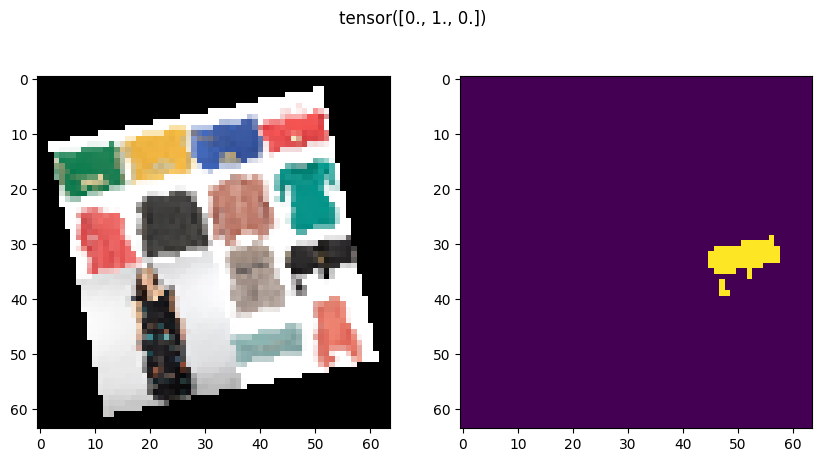

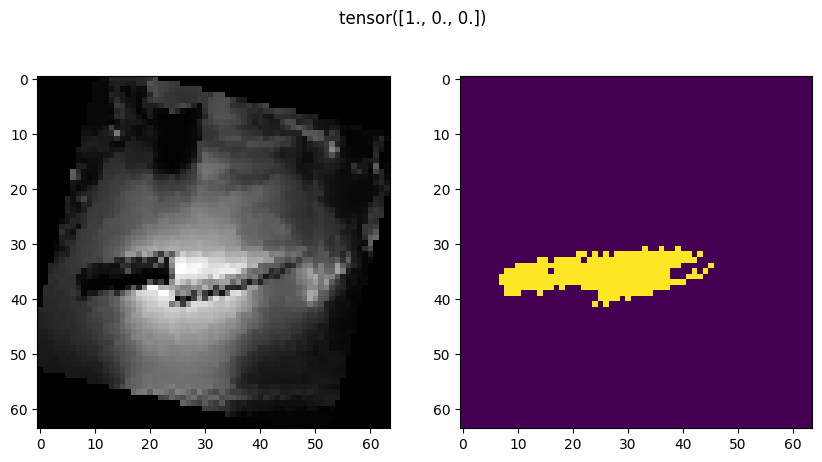

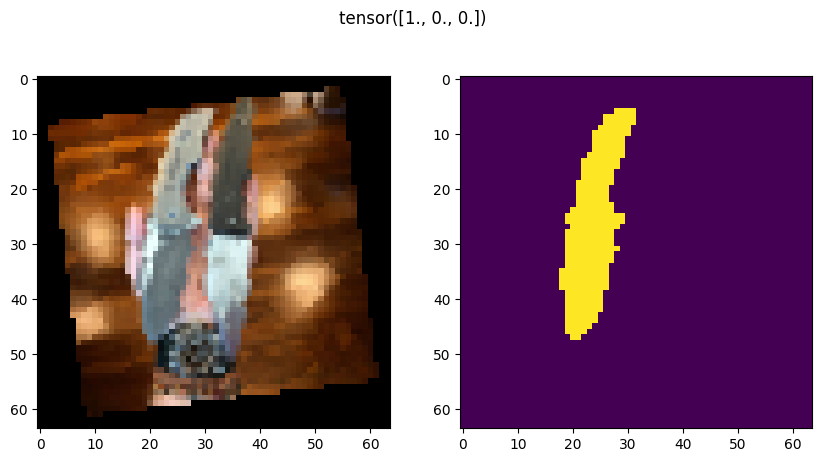

In [15]:
import random

def imshow_sample(img, ax):
    img = img.numpy().transpose((1,2,0))
    ax.imshow(img)

def display_sampled_image(dataset, img_nr):
    image, mask, class_name = dataset[img_nr]
    _, axs = plt.subplots(1, 2, figsize = (10, 5))
    plt.suptitle(class_name)
    imshow_sample(image, ax = axs[0])
    imshow_sample(mask, ax = axs[1])

def display_n_sampled_images(dataset, n):
    rand_imgs = [random.randint(0, len(dataset)) for _ in range(n)]
    [display_sampled_image(dataset, r) for r in rand_imgs]

display_n_sampled_images(train_dataset, n=3)

## Model

In [16]:
device = "cuda"

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    
    num_classes = 3   # number of output classes for classification

    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        features = [64, 128, 256, 512]
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2),
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        # Adding a classification head
        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(features[-1] * 2, self.num_classes)
        )

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # classification prediction
        class_prediction = torch.softmax(self.classifier_head(x), dim=1)

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = torch.nn.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)
        
        # segmentation prediction
        segmentation_prediction = torch.sigmoid(self.final_conv(x))

        return segmentation_prediction, class_prediction

In [17]:
def weighted_loss(loss_mask, loss_label):
    return 0.7*loss_mask+0.3*loss_label

def train(model, optimizer, criterion_segmentation, criterion_classification, dataloader, num_epochs):
    global device
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, masks, labels = data
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs_mask, outputs_label = model(inputs)

            loss_mask = criterion_segmentation(outputs_mask, masks)
            loss_label = criterion_classification(outputs_label, labels)
            loss = weighted_loss(loss_mask, loss_label)  # combined loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")
    return running_loss
    
def validate(model, criterion_segmentation, criterion_classification, dataloader):
    global device
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, masks, labels = data
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
           
            outputs_mask, outputs_label = model(inputs)
            
            loss_mask = criterion_segmentation(outputs_mask, masks)
            loss_label = criterion_classification(outputs_label, labels)
            loss = weighted_loss(loss_mask, loss_label)   # combined loss

            running_loss += loss.item()

    print(f"Validation Loss: {running_loss/len(dataloader)}")
    return running_loss


def test(model, dataloader):
    global device
    model.eval()
    total = 0
    dice_score = 0
    all_inputs = []
    all_masks = []
    all_outputs_mask = []
    all_outputs_label = []

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, masks, labels = data
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
               
            outputs_mask, outputs_label = model(inputs)
        
            outputs_mask = (outputs_mask > 0.5).float()
            masks = (masks > 0.5).float()

            intersection = (outputs_mask * masks).sum().item()
            union = outputs_mask.sum().item() + masks.sum().item()
            dice_score += (2. * intersection + 1e-6) / (union + 1e-6)

            total += labels.size(0)

            all_inputs.append(inputs)
            all_masks.append(masks)
            all_outputs_mask.append(outputs_mask)
            all_outputs_label.append(outputs_label)

        iou = dice_score / total

        print(f"Testing IoU is: {dice_score / total}")
    return iou, all_inputs, all_masks, all_outputs_mask, all_outputs_label

num_epochs = 2

# Select device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Loss criterion and Optimizer
criterion_segmentation = nn.BCEWithLogitsLoss()
criterion_classification = nn.CrossEntropyLoss()

In [18]:
model_v1 = UNet().to(device)
optimizer = torch.optim.Adam(model_v1.parameters(), lr=0.0025)

train(model_v1, optimizer, criterion_segmentation, criterion_classification, dataloader=train_dataloader, num_epochs=num_epochs)
validate(model_v1, criterion_segmentation, criterion_classification, dataloader=validation_dataloader)
test_iou, inputs, labels, outputs_mask, outputs_label = test(model_v1, dataloader=test_dataloader)

Epoch 1/2, Loss: 0.8283452432731102
Epoch 2/2, Loss: 0.7774734147663774
Validation Loss: 0.7534010410308838
Testing IoU is: 0.0061655960398907615


In [19]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

space = [Integer(1,128, name="batch_size"),
         Real(10**-5, 10**0, "log-uniform", name="learning_rate")]

num_epochs = 5

def train_and_get_validation_loss(model, train_dataset, validation_dataset, criterion_segmentation, criterion_classification, batch_size, learning_rate):
    global num_epochs

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False, drop_last=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
    _ = train(model, optimizer, criterion_segmentation,  criterion_classification, train_dataloader, num_epochs)
    validation_loss = validate(model, criterion_segmentation,  criterion_classification, validation_dataloader)
    
    return validation_loss

@use_named_args(space)
def objective(**params):
    model = UNet().to(device)
    
    criterion_segmentation = nn.BCEWithLogitsLoss()
    criterion_classification = nn.CrossEntropyLoss()
    
    batch_size = int(params['batch_size'])
    learning_rate = params['learning_rate']
    
    validation_loss = train_and_get_validation_loss(model, train_dataset, validation_dataset, criterion_segmentation, criterion_classification, batch_size, learning_rate)
    
    return validation_loss

res_gp = gp_minimize(objective, space, n_calls=10, random_state=0)

Epoch 1/5, Loss: 0.8320926565390366
Epoch 2/5, Loss: 0.8185514578452477
Epoch 3/5, Loss: 0.817944164459522
Epoch 4/5, Loss: 0.8182478088598985
Epoch 5/5, Loss: 0.8188551022456243
Validation Loss: 0.8131366471449534
Epoch 1/5, Loss: 0.8316139578819275
Epoch 2/5, Loss: 0.8188182645373874
Epoch 3/5, Loss: 0.8182122243775262
Epoch 4/5, Loss: 0.8179091943634881
Epoch 5/5, Loss: 0.8197273678249783
Validation Loss: 0.8131366471449534
Epoch 1/5, Loss: 0.8490759332974752
Epoch 2/5, Loss: 0.7954965631167094
Epoch 3/5, Loss: 0.7775275409221649
Epoch 4/5, Loss: 0.7648326655228933
Epoch 5/5, Loss: 0.7586409399906794
Validation Loss: 0.7447518110275269
Epoch 1/5, Loss: 0.9033742524110354
Epoch 2/5, Loss: 0.8575073297207172
Epoch 3/5, Loss: 0.830403710787113
Epoch 4/5, Loss: 0.8152306469587179
Epoch 5/5, Loss: 0.7918405601611505
Validation Loss: 0.8387012581030527
Epoch 1/5, Loss: 0.8217192462512425
Epoch 2/5, Loss: 0.7673621496983937
Epoch 3/5, Loss: 0.7605077879769462
Epoch 4/5, Loss: 0.75759760822

In [20]:
best_batch_size, best_learning_rate = res_gp.x
best_score = res_gp.fun
all_scores = res_gp.func_vals

best_batch_size, best_learning_rate, best_score

(36, 0.0024452630570839917, 4.359716832637787)

In [21]:
best_model = UNet()
best_model.to(device)
num_epochs = 10

best_batch_size, best_learning_rate, best_score = (36, 0.0024452630570839917, 4.327942848205566)

validation_loss = train_and_get_validation_loss(best_model, train_dataset, validation_dataset, criterion_segmentation, criterion_classification, batch_size=int(best_batch_size), learning_rate=best_learning_rate)

test_iou, inputs, labels, outputs_mask, outputs_label = test(best_model, dataloader=test_dataloader)

Epoch 1/10, Loss: 0.8280717070613589
Epoch 2/10, Loss: 0.7724249022347587
Epoch 3/10, Loss: 0.7659901870148522
Epoch 4/10, Loss: 0.7561586882386889
Epoch 5/10, Loss: 0.7563432518924985
Epoch 6/10, Loss: 0.7585938147136143
Epoch 7/10, Loss: 0.7502591503517968
Epoch 8/10, Loss: 0.7535327736820493
Epoch 9/10, Loss: 0.7505557175193515
Epoch 10/10, Loss: 0.7506717422178814
Validation Loss: 0.7103316485881805
Testing IoU is: 0.015592548393014214


In [22]:
test_iou, inputs, labels, outputs_mask, outputs_label = test(best_model, dataloader=test_dataloader)

Testing IoU is: 0.015537610319311529


In [23]:
def imshow_result(img, ax):
    img = img[0].cpu().data.numpy().transpose((1,2,0))
    ax.imshow(img)

def display_result(inputs, labels, outputs, nr):
    _, axs = plt.subplots(1,3)
    imshow_result(img =  inputs[nr], ax = axs[0])
    imshow_result(img =  labels[nr], ax = axs[1])
    imshow_result(img =  outputs[nr], ax = axs[2])

def display_results(inputs, labels, outputs, nrs):
    [display_result(inputs, labels, outputs, n) for n in nrs]

## Mask predictions

In [26]:
outputs_label[0:5]

[tensor([[3.0679e-03, 9.9384e-01, 3.0949e-03],
         [5.2063e-20, 1.0000e+00, 1.4690e-15],
         [9.8301e-01, 1.5323e-02, 1.6692e-03],
         [9.9676e-01, 3.1208e-03, 1.1927e-04],
         [1.3806e-04, 9.9926e-01, 6.0313e-04],
         [9.8939e-01, 9.8559e-03, 7.5842e-04],
         [9.9596e-01, 3.8654e-03, 1.7246e-04],
         [4.6560e-23, 1.0000e+00, 3.9392e-18],
         [9.2408e-01, 6.8742e-02, 7.1742e-03],
         [9.7748e-01, 2.0544e-02, 1.9725e-03],
         [9.6897e-01, 2.7304e-02, 3.7250e-03],
         [3.9511e-01, 5.0874e-01, 9.6150e-02],
         [1.4328e-01, 7.8070e-01, 7.6020e-02],
         [9.9414e-01, 5.5680e-03, 2.8917e-04],
         [8.0676e-20, 1.0000e+00, 4.7685e-15],
         [9.8773e-01, 1.1250e-02, 1.0232e-03],
         [2.3514e-04, 9.9658e-01, 3.1819e-03],
         [8.4750e-01, 1.1172e-01, 4.0781e-02],
         [9.1375e-01, 7.9686e-02, 6.5668e-03],
         [2.5534e-18, 1.0000e+00, 1.9347e-13],
         [1.9909e-21, 1.0000e+00, 2.1519e-16],
         [9.8

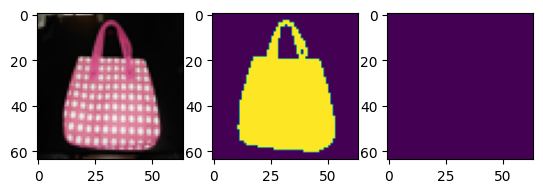

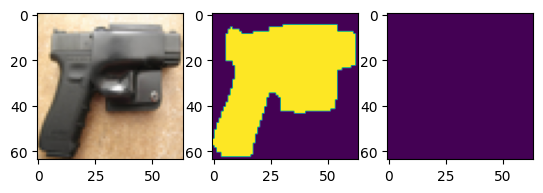

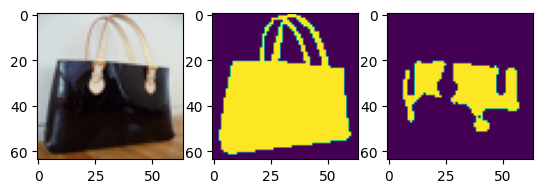

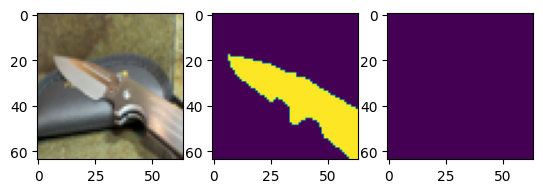

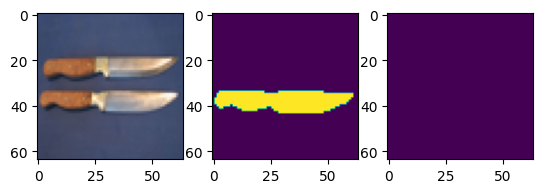

In [24]:
display_results(inputs, labels, outputs_mask, nrs = range(5))

# To fix:
- early stopping for epoch selection
- one model for three masks + class predictions - need to change to multilabel classification
- use initialization weights from resnet [won't do]
- take new images as inputs for our showcase